<a href="https://colab.research.google.com/github/pardalin/ner-target-sent-classification/blob/main/NER_%2B_sentiment_classification_on_marked_target.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NER + sentiment classification on marked target

This is a course project I did for Deep Learning in Human Language Technology -course @ University of Turku.



## Named Entity Recognition

In [ ]:
!pip3 install -q transformers datasets seqeval

     |████████████████████████████████| 4.2 MB 5.4 MB/s 
     |████████████████████████████████| 346 kB 74.6 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 596 kB 68.2 MB/s 
     |████████████████████████████████| 86 kB 5.7 MB/s 
     |████████████████████████████████| 6.6 MB 53.8 MB/s 
     |████████████████████████████████| 86 kB 6.5 MB/s 
     |████████████████████████████████| 212 kB 74.1 MB/s 
     |████████████████████████████████| 140 kB 77.0 MB/s 
     |████████████████████████████████| 1.1 MB 61.7 MB/s 
     |████████████████████████████████| 127 kB 35.1 MB/s 
     |████████████████████████████████| 271 kB 29.8 MB/s 
     |████████████████████████████████| 144 kB 55.5 MB/s 
     |████████████████████████████████| 94 kB 1.8 MB/s 
     |████████████████████████████████| 112 kB 52.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of 

In [ ]:
import logging
import datasets
from pprint import PrettyPrinter
import transformers
import torch
from collections import defaultdict

pprint = PrettyPrinter(compact=True).pprint
logging.disable(logging.INFO)

In [ ]:
def tokenize_and_align_labels(example):
    # adapted from https://huggingface.co/docs/transformers/custom_datasets#tok_ner
    tokenized = tokenizer(example["tokens"], truncation=True, padding=True, is_split_into_words=True)
    tags = example['ner_tags']
    word_ids = tokenized.word_ids()

    labels = []
    previous_word_idx = None
    for word_idx in word_ids:
        # Special tokens have word id None. Set their label to -100 so they
        # are automatically ignored in the loss function.
        if word_idx is None:
            labels.append(-100)
        # Set the label for the first token of each word normally.
        elif word_idx != previous_word_idx:
            labels.append(tags[word_idx])
        # For subsequent tokens in a word, set the label to -100.
        else:
            labels.append(-100)
        previous_word_idx = word_idx

    tokenized["labels"] = labels
    return tokenized


class LogSavingCallback(transformers.TrainerCallback):
    def on_train_begin(self, *args, **kwargs):
        self.logs = defaultdict(list)
        self.training = True

    def on_train_end(self, *args, **kwargs):
        self.training = False

    def on_log(self, args, state, control, logs, model=None, **kwargs):
        if self.training:
            for k, v in logs.items():
                if k != "epoch" or v not in self.logs[k]:
                    self.logs[k].append(v)

def compute_metrics(outputs_and_labels):
    outputs, labels = outputs_and_labels
    predictions = outputs.argmax(axis=2)

    # Remove ignored indices (special tokens)
    token_predictions = [
        [tag_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    token_labels = [
        [tag_names[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(
        predictions=token_predictions,
        references=token_labels
    )

    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

training_logs = LogSavingCallback()

In [ ]:
model_name = "TurkuNLP/bert-base-finnish-cased-v1"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name, padding='max_length', truncation=True, max_length=512)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/414k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/796k [00:00<?, ?B/s]

In [ ]:
dataset_ner = datasets.load_dataset("turku_ner_corpus")
dataset_ner = dataset_ner.shuffle()
dataset_ner = dataset_ner.map(tokenize_and_align_labels)

Using custom data configuration default


Generating train split:   0%|          | 0/12217 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1364 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1555 [00:00<?, ? examples/s]

Dataset turku_ner_corpus downloaded and prepared to /root/.cache/huggingface/datasets/turku_ner_corpus/default/1.0.0/64d6e96666b88e03014617db39238ab6fbcaf5b22e6ab2180ff16bd39823ce95. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12217 [00:00<?, ?ex/s]

  0%|          | 0/1364 [00:00<?, ?ex/s]

  0%|          | 0/1555 [00:00<?, ?ex/s]

In [ ]:
tag_names = dataset_ner["train"].features["ner_tags"].feature.names
print(tag_names)
ner_id2label = {}
for i in range(len(tag_names)):
  ner_id2label[i] = tag_names[i]

print(ner_id2label)


['B-DATE', 'B-EVENT', 'B-LOC', 'B-ORG', 'B-PER', 'B-PRO', 'I-DATE', 'I-EVENT', 'I-LOC', 'I-ORG', 'I-PER', 'I-PRO', 'O']
{0: 'B-DATE', 1: 'B-EVENT', 2: 'B-LOC', 3: 'B-ORG', 4: 'B-PER', 5: 'B-PRO', 6: 'I-DATE', 7: 'I-EVENT', 8: 'I-LOC', 9: 'I-ORG', 10: 'I-PER', 11: 'I-PRO', 12: 'O'}


In [ ]:
ner_model = transformers.AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(tag_names), id2label=ner_id2label)

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpo

In [ ]:
trainer_args = transformers.TrainingArguments(
    "checkpoints",
    evaluation_strategy="steps",
    logging_strategy="steps",
    load_best_model_at_end=True,
    eval_steps=100,
    logging_steps=100,
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    max_steps=1600,
)

In [ ]:
metric = datasets.load_metric("seqeval")

data_collator = transformers.DataCollatorForTokenClassification(tokenizer)

# Argument gives the number of steps of patience before early stopping
early_stopping = transformers.EarlyStoppingCallback(
    early_stopping_patience=5
)

In [ ]:
trainer_ner = transformers.Trainer(
    model=ner_model,
    args=trainer_args,
    train_dataset=dataset_ner["train"],
    eval_dataset=dataset_ner["validation"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer = tokenizer,
    callbacks=[early_stopping, training_logs]
)

trainer_ner.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,0.257500,0.104374,0.702304,0.716839,0.709497,0.969904
200,0.096100,0.085092,0.766938,0.798683,0.782488,0.979736
300,0.080900,0.084227,0.780109,0.804327,0.792033,0.979299
400,0.067900,0.074763,0.779535,0.788335,0.783910,0.982139
500,0.063000,0.059250,0.847909,0.839135,0.843499,0.985198
600,0.058200,0.067087,0.825964,0.825964,0.825964,0.983614
700,0.071800,0.057896,0.829222,0.822201,0.825697,0.984815
800,0.054700,0.051249,0.847092,0.849483,0.848286,0.986618
900,0.043800,0.058166,0.863680,0.852305,0.857955,0.986399
1000,0.045800,0.056754,0.855263,0.856068,0.855665,0.986946


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=1600, training_loss=0.06595975831151009, metrics={'train_runtime': 258.9393, 'train_samples_per_second': 49.432, 'train_steps_per_second': 6.179, 'total_flos': 274579768020468.0, 'train_loss': 0.06595975831151009, 'epoch': 1.05})

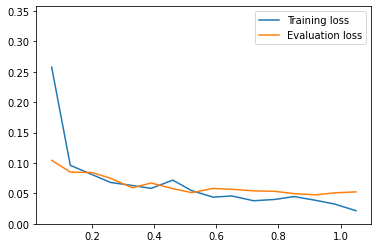

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot(logs, keys, labels):
    values = sum([logs[k] for k in keys], [])
    plt.ylim(max(min(values)-0.1, 0.0), min(max(values)+0.1, 1.0))
    for key, label in zip(keys, labels):    
        plt.plot(logs["epoch"], logs[key], label=label)
    plt.legend()
    plt.show()

plot(training_logs.logs, ["loss", "eval_loss"], ["Training loss", "Evaluation loss"])

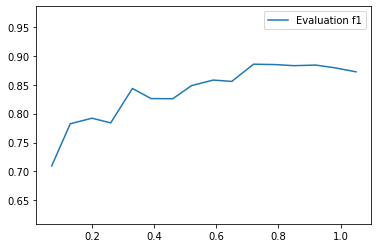

In [ ]:
plot(training_logs.logs, ["eval_f1"], ["Evaluation f1"])

In [ ]:
ner_test_results = trainer_ner.predict(dataset_ner["test"]) # I wanted to make sure that doing predictions on the test set would give me similar results than above

In [ ]:
pprint(ner_test_results.metrics) #the f1 seems in line with above, so I am confident that the model is performing as it should on new, unseen data

{'test_accuracy': 0.9887475073592251,
 'test_f1': 0.8906560636182901,
 'test_loss': 0.05089566484093666,
 'test_precision': 0.8897715988083416,
 'test_recall': 0.891542288557214,
 'test_runtime': 4.7567,
 'test_samples_per_second': 326.91,
 'test_steps_per_second': 40.995}


In [ ]:
ner_model.save_pretrained("ner-model")

My code for NER here is very similar to what we did during the demos. I did a lot of experimenting with different parameters, mainly learning rate and batch size, and found a lr of 5e-5 and a batch size of 8 to work consistently well.

As said on the lectures, accuracy is not a good metric here. If the model predicted "O" for all tokens, the accuracy would still be high, as the vast majority of tokens are not named entities and thus receive the label "O". This is why I'm paying attention to the F1 score here.

The F1 score on the validation dataset is setting on approx. .87, and on the test set I got an F1 of almost .91 - I am happy with these numbers, even though they are far behind state-of-the-art Finnish NER systems that can reach .93, but with this being "just" a course project, I'm satisfied with these numbers.

---

## Sentiment target classification

In [ ]:
!wget -nc https://raw.githubusercontent.com/TurkuNLP/sentiment-target-corpus/main/sentiment-target-fi.tsv

--2022-06-13 14:50:42--  https://raw.githubusercontent.com/TurkuNLP/sentiment-target-corpus/main/sentiment-target-fi.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 667607 (652K) [text/plain]
Saving to: ‘sentiment-target-fi.tsv’

sentiment-target-fi 100%[===================>] 651.96K  --.-KB/s    in 0.04s   

2022-06-13 14:50:46 (15.6 MB/s) - ‘sentiment-target-fi.tsv’ saved [667607/667607]



In [ ]:
lines = []
with open("sentiment-target-fi.tsv") as f:    # open file
    for line in f:    # iterate over lines in file
        line = line.rstrip("\n")    # remove newline character
        lines.append(line)    # store line in list

for line in lines[:10]:    # iterate over first ten lines
    print(line)    # print each line

#ID	text	majority	agreement	annotations
comments2015d-45552-1.1	<TARGET>Kuopionlahden</TARGET> vierasvenelaituri (kuten nimi oikeasti on) on mielestämme tosi kiva.	positive	0.6666666666666666	positive,positive,neither,positive,neither,positive
comments2014a-469816-3.1	Käytetyssä <TARGET>Meganessa</TARGET> yksi etu verrattuna vaikkapa Skoda Octaviaan on se että Meganen voi ostaa jonkun vuoden uudempana.	positive	1.0	positive,positive,positive,positive,positive,positive
comments2007d-182055-6.1	Monet heistä ovat olleet kymmeniä vuosia <TARGET>Finnairin</TARGET> palveluksessa ja nyt tulee kenkää.	negative	0.8	negative,negative,negative,neither,negative
threads2013a-835251-2.1	<TARGET>Keskusta</TARGET> on aina ollut (ja on oleva) muun Suomen tuki ja turva.	positive	1.0	positive,positive,positive
comments2009a-483243-7.1	Itselläni on vuosimallin -93 <TARGET>LS-400</TARGET> ja olen tyytyväinen.	positive	1.0	positive,positive,positive,positive,positive
comments2003a-590164-4.1	<TARGET>The Bea

In [ ]:
import re
import json

label_names=["positive","negative","reject","neither"]
data=[]
with open("sentiment-target-fi.tsv") as f:
    for line in f:
        line=line.rstrip("\n")
        if not line or line.startswith("#"): #skip empty and comments (incl. header)
            continue
        cols=line.split("\t")
        if len(cols)!=5: #skip weird lines that don't have the right number of columns
            continue
        data.append(cols)

In [ ]:
import random

random.seed(41191)    # seed with arbitrary integer value
random.shuffle(data) # produces arbitrary but fixed order

In [ ]:
with open("sentiment-data.jsonl", "wt") as f:
    for cols in data:
        item = {
            "text": cols[1],
            "label": label_names.index(cols[2]),    # translate from label strings to integers
        }
        print(json.dumps(item,ensure_ascii=False,sort_keys=True),file=f)

In [ ]:
examples = []
with open("sentiment-data.jsonl") as f:
    for line in f:
        example = json.loads(line)
        examples.append(example)

pprint(examples[0])

{'label': 1,
 'text': 'sit kertoa terveiseni etiä päin, että MIKSI <TARGET>WM6</TARGET> '
         'pitää bootata viikon-kahden välein, kun vetää hirteen JA ei tee '
         'mitään enään!?'}


In [ ]:
import datasets

file_name = "sentiment-data.jsonl"
sent_dataset = datasets.load_dataset(
    'json',                             # Format of the data
    data_files={"everything":file_name},    # All data files, here we only have one
    split={
        "train":"everything[:80%]",  # First 80% is the train set
        "validation":"everything[80%:90%]",   # Next 10% is the validation/dev set
        "test":"everything[90%:]"    # last 10% is the test set
    },
    features=datasets.Features({    # Here we tell how to interpret the attributes
        "label":datasets.ClassLabel(names=label_names),
        "text":datasets.Value("string")
    })
)

Using custom data configuration default-c49a0217caf40e36


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-c49a0217caf40e36/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
pprint(sent_dataset["train"][0])

{'label': 1,
 'text': 'sit kertoa terveiseni etiä päin, että MIKSI <TARGET>WM6</TARGET> '
         'pitää bootata viikon-kahden välein, kun vetää hirteen JA ei tee '
         'mitään enään!?'}


In [ ]:
def tokenize(example):
    return tokenizer(
        example["text"],
        max_length=512,
        truncation=True,
    )

In [ ]:
sent_dataset = sent_dataset.map(tokenize)

  0%|          | 0/2743 [00:00<?, ?ex/s]

  0%|          | 0/343 [00:00<?, ?ex/s]

  0%|          | 0/343 [00:00<?, ?ex/s]

In [ ]:
sent_id2label = {}
for i in range(len(label_names)):
  sent_id2label[i] = label_names[i]

print(sent_id2label)

{0: 'positive', 1: 'negative', 2: 'reject', 3: 'neither'}


In [ ]:
sent_model = transformers.AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_names), id2label=sent_id2label)

Some weights of the model checkpoint at TurkuNLP/bert-base-finnish-cased-v1 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the m

In [ ]:
# Set training arguments
senti_trainer_args = transformers.TrainingArguments(
    "checkpoints",
    evaluation_strategy="steps",
    logging_strategy="steps",
    load_best_model_at_end=True,
    eval_steps=100,
    logging_steps=100,
    learning_rate=2e-5,
    weight_decay=0.005,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    max_steps=600,
)

In [ ]:
accuracy = datasets.load_metric("accuracy")

def compute_accuracy(outputs_and_labels):
    outputs, labels = outputs_and_labels
    predictions = outputs.argmax(axis=-1) #pick the index of the "winning" label
    return accuracy.compute(predictions=predictions, references=labels)


data_collator = transformers.DataCollatorWithPadding(tokenizer)

# Argument gives the number of steps of patience before early stopping
early_stopping = transformers.EarlyStoppingCallback(
    early_stopping_patience=5
)

In [ ]:
sent_trainer = transformers.Trainer(
    model=sent_model,
    args=senti_trainer_args,
    train_dataset=sent_dataset["train"],
    eval_dataset=sent_dataset["validation"],
    compute_metrics=compute_accuracy,
    data_collator=data_collator,
    tokenizer = tokenizer,
    callbacks=[early_stopping, training_logs]
)

sent_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Step,Training Loss,Validation Loss,Accuracy
100,0.901800,0.661331,0.737609
200,0.729800,0.620136,0.763848
300,0.656900,0.633780,0.775510
400,0.678800,0.619929,0.795918
500,0.578900,0.641190,0.793003
600,0.535300,0.676731,0.787172


TrainOutput(global_step=600, training_loss=0.6802627563476562, metrics={'train_runtime': 69.7093, 'train_samples_per_second': 34.429, 'train_steps_per_second': 8.607, 'total_flos': 54259407276672.0, 'train_loss': 0.6802627563476562, 'epoch': 0.87})

In [ ]:
eval_results = sent_trainer.evaluate(sent_dataset["validation"])

pprint(eval_results)

print('Accuracy:', eval_results['eval_accuracy'])

{'epoch': 0.87,
 'eval_accuracy': 0.793002915451895,
 'eval_loss': 0.641190230846405,
 'eval_runtime': 1.2286,
 'eval_samples_per_second': 279.184,
 'eval_steps_per_second': 69.999}
Accuracy: 0.793002915451895


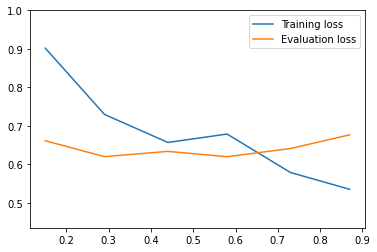

In [ ]:
plot(training_logs.logs, ["loss", "eval_loss"], ["Training loss", "Evaluation loss"])

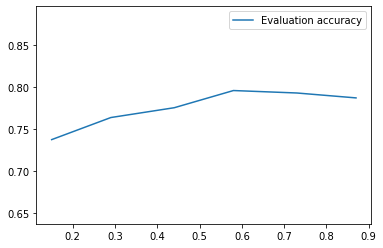

In [ ]:
plot(training_logs.logs, ["eval_accuracy"], ["Evaluation accuracy"])

In [ ]:
sent_test_results = sent_trainer.predict(sent_dataset["test"]) # same as with NER, I do predictions on the test set to see if I get a similar accuracy...

In [ ]:
pprint(sent_test_results.metrics) # ... and I do, so onwards we go

{'test_accuracy': 0.7871720116618076,
 'test_loss': 0.6796692609786987,
 'test_runtime': 1.5227,
 'test_samples_per_second': 225.256,
 'test_steps_per_second': 56.478}


This model was a lot harder to train than the NER model. The model became very easily overfitted and training was inconsistent. After a lot of trial and error, I found these parameters to function reasonably well and to give quite consistent results.

---

## Combining the two models

In [ ]:
# I am using dummy sentences to test the combination of the models

testilauseita = ["Kerran kävelin Yritys Oy:n ovista sisään, ja toiste en todellakaan mene.",
                 "Minusta Automerkki on ihan ok, tosin huoltaa pitää usein.",
                 "Katsoin Matti Meikäläisen ohjelman kerran televisiosta, enkä pitänyt siitä.",
                 "Onko sinullakin jo Firma AB:n upea ja hieno Tuote?",
                 "Jouduin mainonnan uhriksi ja ostin Firma AB:n Tuotteen, ja se jos mikä kaduttaa.",
                 "Asun aivan Yrityksen vieressä, käyn siellä joskus.",
                 "Oletko ostanut Tuote 312:n?"
                 ]

In [ ]:
from transformers import pipeline

# this is the pipeline for the NER model. I am using the fine-tuned ner_model and the same tokenizer as used earlier.
#I use the "first" aggregation strategy for easier processing later on.
#device=0 tells the pipeline to use the GPU, passing an empty list to ignore_labels because it defaults to "0" and
#thus would return only named entities.

ner_pipe = pipeline("ner", model=ner_model, tokenizer=tokenizer, device=0, batch_size=8, aggregation_strategy="first", ignore_labels=[])

results = ner_pipe(testilauseita)



In [ ]:

# I wrote this function to write the target tags for the text. It is not perfect, as it marks only the first instance as a target,
# so if there's a sentence where a product and an organization is mentioned, only the first one will get marked as a target.
# This way, there will only be one target per sentence, which is of course good, but it lacks the ability to choose a target
# that was mentioned later in the sentence if there was a product or organization earlier on.
# Only products or organizations are marked as targets.

def writing_target_tags(sentence):
  output = []
  for word in sentence:
    text = word["word"]
    if word["entity_group"] == 'O':
      output.append(text)
    elif word["entity_group"] == 'PRO':
      if "<TARGET>" in output:
        output.append(text)
      else:
        output.append("<TARGET>")
        output.append(text)
        output.append("</TARGET>")
    elif word["entity_group"] == 'ORG':
      if "<TARGET>" in output:
        output.append(text)
      else:
        output.append("<TARGET>")
        output.append(text)
        output.append("</TARGET>")
  output_lause = " ".join(output) # in the end I join the elements together with a space between them, creating a string of the sentence with the tags in place.
  return output_lause


uudet_lauseet = []

for lause in results:
  uudet_lauseet.append(writing_target_tags(lause))


uudet_lauseet_filtered = []

for lause in uudet_lauseet: # I filter out sentences where there is no target, so sentences that only mentioned people or where there were no named entities etc.
  if "<TARGET>" in lause:
    uudet_lauseet_filtered.append(lause)



In [ ]:
sent_pipe = pipeline("sentiment-analysis", model=sent_model, tokenizer=tokenizer, device=0, batch_size=4, function_to_apply="softmax")
sent_results = sent_pipe(uudet_lauseet_filtered)

In [ ]:
for lause, tulos in zip(uudet_lauseet_filtered, sent_results): # as the sent_results do not have the original sentence anymore, I am going through both to print the sentence with the predicted label
  print("Lause:", lause, "LABEL:", tulos["label"])

Lause: Kerran kävelin <TARGET> Yritys Oy : n </TARGET> ovista sisään, ja toiste en todellakaan mene. LABEL: negative
Lause: Minusta <TARGET> Automerkki </TARGET> on ihan ok, tosin huoltaa pitää usein. LABEL: positive
Lause: Onko sinullakin jo <TARGET> Firma AB : n </TARGET> upea ja hieno Tuote? LABEL: positive
Lause: Jouduin mainonnan uhriksi ja ostin <TARGET> Firma AB : n </TARGET> Tuotteen , ja se jos mikä kaduttaa. LABEL: negative
Lause: Asun aivan <TARGET> Yrityksen </TARGET> vieressä, käyn siellä joskus. LABEL: neither
Lause: Oletko ostanut <TARGET> Tuote 312 : n </TARGET> ? LABEL: neither


**Comments & discussion**

I used pipeline() to make pipelines for both models, feeding the test sentences first through the NER pipeline, changing relevant NER tags to target tags and feeding those sentences to the sentiment analysis pipeline.

This is a very "hard-coded" approach here, and work could be done to streamline this process better so that it would more resemble a system where you could just call one (main) function to the dataset and then other defined functions would take care of everything.

It also only marks the first relevant named entity as a target, so for example in a sentence like "Kävin Yritys Oy:n liikkeessä ja ostin sieltä Tuote 3000:n, Yritys Oy on hyvä mutta tuote huono", where there are multiple relevant entities (Yritys Oy mentioned twice, Tuote 3000 mentioned once) this code is capable of marking only the first mention of Yritys Oy as a target.

---



## Further streamlining for large scale use

In [ ]:
import re

def find_target(sentence): #I found this on https://appdividend.com/2021/12/09/how-to-find-string-between-two-strings-in-python/
  result = re.search('<TARGET> (.*) </TARGET>', sentence)
  return result.group(1)

def both_models_pipeline(data):
  ner_results = ner_pipe(data)
  ner_results_with_targets = []
  for line in ner_results:
    ner_results_with_targets.append(writing_target_tags(line))
  filtered_ner_results_with_targets = []
  for line in ner_results_with_targets:
    if "<TARGET>" in line:
      target = find_target(line)
      if len(target) > 1: # this is a kind of a final cleaning step, filtering out one-letter targets, as they probably are errors or junk
        filtered_ner_results_with_targets.append(line)
      else:
        continue
    else:
      continue
  sent_analysis_results = sent_pipe(filtered_ner_results_with_targets)
  final_results = []
  for line, label in zip(filtered_ner_results_with_targets, sent_analysis_results):
    final_results.append([line, label["label"]])
  return final_results